# Cronh

## Librerías

In [1]:
import os
import random
import datetime

# Datos
import numpy as np
import pandas as pd

# Gráficos
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix
from IPython.display import SVG

# Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model, model_to_dot
from tensorflow.keras import layers
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import CSVLogger
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, ReLU, Softmax, BatchNormalization, Dropout
from tensorflow.random import set_seed

from sklearn.metrics import classification_report

# To supress any warnings during the flow
import warnings
warnings.filterwarnings('ignore')

2023-07-05 11:58:56.480043: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Configuración

In [2]:
tf.config.set_visible_devices([], 'GPU')

# if tf.test.gpu_device_name(): # this lies and tells you about all devices
if tf.config.experimental.list_logical_devices('GPU'):
    print('GPU found')
else:
    print("No GPU found")

No GPU found


## Constantes

In [3]:
PATH = "../../"

# Ruta del archivo CSV que contiene las etiquetas y rutas de las imágenes
csv_file = PATH + "CSVs/dataset/train.csv"
PATH_IMAGENES = PATH + "Dataset/"

# Rutas de los archivos CSV que contienen las etiquetas y rutas de las imágenes
TRAIN_CSV = PATH + "CSVs/dataset/train.csv"
VAL_CSV = PATH + "CSVs/dataset/val.csv"
TEST_CSV = PATH + "CSVs/dataset/test.csv"

# Directorio de las imágenes originales
imgs_path = PATH + "Dataset/"

# Directorio donde se almacenarán las imágenes divididas
split_path = PATH + "SplitDataset/"
train_dir = split_path + "train/"
val_dir = split_path + "val/"
test_dir = split_path + "test/"

In [4]:
# Preprocesamiento
BATCH_SIZE = 32

TARGET_IMG_WIDTH = 224
TARGET_IMG_HEIGHT = 224
TARGET_IMG_CHANNELS = 3
TARGET_SIZE = [TARGET_IMG_WIDTH, TARGET_IMG_HEIGHT]
TARGET_SHAPE = [TARGET_IMG_WIDTH, TARGET_IMG_HEIGHT, TARGET_IMG_CHANNELS]

NUM_EPOCHS = 100

# Modelo
MODEL_NAME = "Cronh_v2"

CHECKPOINT_MONITOR = 'val_accuracy'
CHECKPOINT_MODE = 'max'

EARLYSTOP_MONITOR = 'val_loss'
EARLYSTOP_PATIENCE = 25 # int(NUM_EPOCHS/4)

LR_MONITOR = 'val_loss'
LR_FACTOR = 0.5
LR_PATIENCE = 10 # int(NUM_EPOCHS / 10)
LR_MINLR = 0.0001

NUM_CLASSES = 8

INITIAL_WEIGHTS = 'imagenet'

# Train
OPTIMIZER = "adam"
LOSS = 'sparse_categorical_crossentropy'
METRICS = ["accuracy"]

DROPOUT_FACTOR = 0.2

In [5]:
# Obtener la fecha y hora actual
current_datetime = datetime.datetime.now().strftime("%Y%m%d_%H%M")

### Callback

#### ModelCheckpoint

**ModelCheckpoint** guardará los modelos en cada época donde se cumpla la condición **val_accuracy sea el máximo alcanzado hasta el momento**

In [6]:
# Definir el patrón de nombres para los archivos de modelos guardados
checkpoint_filename = f"best_model_{current_datetime}_val_acc_{{val_accuracy:.4f}}.h5"

# Combinar el directorio y el patrón de nombres
checkpoint_path = PATH + "Models/" + MODEL_NAME + "/" + checkpoint_filename

# Definir el callback ModelCheckpoint
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    monitor=CHECKPOINT_MONITOR,
    mode=CHECKPOINT_MODE,
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

#### Early Stopping

**EarlyStopping**: Detiene el entrenamiento si no se observa una mejora en la métrica especificada durante un número determinado de épocas consecutivas. Ayuda a evitar el overfitting y a ahorrar tiempo de entrenamiento.

In [7]:
# Definir Early Stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor=EARLYSTOP_MONITOR,
    patience=EARLYSTOP_PATIENCE,
    restore_best_weights=True
)

#### ReduceLROnPlateau

**ReduceLROnPlateau**: Reduce la tasa de aprendizaje (learning rate) cuando una métrica monitoreada deja de mejorar. Esto puede ayudar a ajustar mejor el modelo durante el entrenamiento y mejorar su convergencia.

- monitor: la métrica a monitorear
- factor: el factor de reducción del learning rate
- patience: el número de épocas sin mejora antes de reducir el learning rate
- mode: si se debe maximizar o minimizar la métrica

In [8]:
# Definir ReduceLROnPlateau
# Politicas de LR
reduce_lr = ReduceLROnPlateau(
    monitor=LR_MONITOR,
    factor=LR_FACTOR,
    patience=LR_PATIENCE,
    min_lr=LR_MINLR,
    verbose = 1)
# monitor = mean_absolute_error

#### TensorBoard

**TensorBoard**: Permite visualizar métricas, gráficas y otros detalles del entrenamiento en TensorBoard, una herramienta de visualización de TensorFlow. Proporciona una interfaz gráfica para analizar y comparar los resultados del entrenamiento a lo largo del tiempo.

In [9]:
# Definir TensorBoard
log_dir = PATH + "Logs/" + MODEL_NAME + "/"
# tensorboard = TensorBoard(log_dir=log_dir)

tensorboard = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1,
    write_graph=True,
    write_images=True,
    update_freq='epoch',
    embeddings_freq=1,
    )

# Una vez iniciado el entrenamiento, en la terminal ejecutar:
# tensorboard --logdir=/content/drive/MyDrive/NeuralNetwork/logs/
# tensorboard --logdir=Logs/MobileNetV2/

#### CSVLogger

**CSVLogger**: Registra las métricas de entrenamiento y validación en un archivo CSV. Permite realizar un seguimiento de las métricas a lo largo del tiempo y analizarlas posteriormente.

In [10]:
# Definir CSVLogger

# Definir el nombre del archivo con la fecha incluida
csvlogger_filename = PATH + "CSVLogs/" + MODEL_NAME + "/" + current_datetime + "_training.log"

csv_logger = CSVLogger(filename=csvlogger_filename)

In [11]:
CALLBACKS = [early_stopping, checkpoint, reduce_lr, tensorboard, csv_logger]

## Funciones Auxiliares

In [12]:
def plot_training(csvlogger):
    # Cargar los datos del archivo CSV
    log_data = pd.read_csv(csvlogger)

    # Graficar la pérdida y la precisión
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(log_data['epoch'], log_data['loss'], label='Training Loss')
    plt.plot(log_data['epoch'], log_data['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(log_data['epoch'], log_data['accuracy'], label='Training Accuracy')
    plt.plot(log_data['epoch'], log_data['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()
    
def ConfusionMatrix(model, ds, label_list):
# Note: This logic doesn't work with shuffled datasets
    plt.figure(figsize=(15,15))
    y_pred = model.predict(ds)
    predicted_categories = tf.argmax(y_pred, axis=1)
    true_categories = tf.concat([y for x, y in ds], axis=0)
    cm = metrics.confusion_matrix(true_categories,predicted_categories) # last batch 
    sns.heatmap(cm, annot=True, xticklabels=label_list, yticklabels=label_list, cmap="YlGnBu", fmt='g')
    plt.show()

# Clases verticales -> cada fila es una clase real
# Clases horizontales -> clase predicha por el modelo
def NotShuffled_ConfusionMatrix(y_pred, ds, label_list):
# Note: This logic doesn't work with shuffled datasets
    plt.figure(figsize=(15,15))
    predicted_categories = tf.argmax(y_pred, axis=1)
    true_categories = tf.concat([y for x, y in ds], axis=0)
    cm = metrics.confusion_matrix(true_categories,predicted_categories) # last batch
    sns.heatmap(cm, annot=True, xticklabels=label_list, yticklabels=label_list, cmap="YlGnBu", fmt='g')
    plt.show()

def plot_image(pred_array, true_label, img, class_names):
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(pred_array)
  if predicted_label == true_label:
    color = 'green'
  else:
    color = 'red'

  plt.xlabel("Clase: {} | Pred: {} {:2.0f}%".format(class_names[true_label],
                                                class_names[predicted_label],
                                                100 * np.max(pred_array)),
                                                color=color)

def plot_predictions(y_pred, ds):
    true_categories = tf.concat([y for x, y in ds], axis=0)
    images = tf.concat([x for x, y in ds], axis=0)
    class_names = test_data.class_names
    # Randomly sample 15 test images and plot it with their predicted labels, and the true labels.
    indices = random.sample(range(len(images)), 15)
    # Color correct predictions in blue and incorrect predictions in red.
    num_rows = 5
    num_cols = 3
    num_images = num_rows*num_cols
    plt.figure(figsize=(4*num_cols, 2*num_rows))
    for i,index in enumerate(indices):
      plt.subplot(num_rows, num_cols, i+1)
      plot_image(y_pred[index], true_categories[index], images[index],class_names)
    plt.tight_layout()
    plt.show()

def save_report(y_pred, ds, name = ""):
    y_pred_bool = np.argmax(y_pred, axis=1)
    true_categories = tf.concat([y for x, y in ds], axis=0)
    report = classification_report(true_categories, y_pred_bool, output_dict=True)
    df = pd.DataFrame(report).transpose()
    df.to_excel(PATH + "ClassificationReports/" + MODEL_NAME + "/" + name + "classification_report.xlsx", index=True)

In [13]:
# Cargar el archivo CSV en un DataFrame de pandas
df_train = pd.read_csv(TRAIN_CSV)
df_val = pd.read_csv(VAL_CSV)
df_test = pd.read_csv(TEST_CSV)

## Análisis de datos

In [14]:
image_dict = {} # dict to store image array (key) for every class (value)
images = []
count_dict = {} # dict to store count of files (key) for every class (value)

# Obtener las clases únicas del DataFrame
classes = df_train['class'].unique()

# Iterar sobre las clases únicas
for cls in classes:
    # Filtrar el DataFrame por clase
    class_df = df_train[df_train['class'] == cls]

    # Obtener una imagen aleatoria de la clase
    random_index = random.choice(class_df.index)
    image_path = os.path.join(PATH_IMAGENES, class_df.loc[random_index, 'path'])

    # Cargar la imagen usando la función de utilidad de keras y guardarla en image_dict
    img = tf.keras.utils.load_img(image_path)
    image_dict[cls] = img
    images.append(img)

    # Contar el número de imágenes en la clase y guardar el recuento en count_dict
    count_dict[cls] = len(class_df)

### Muestra del dataset

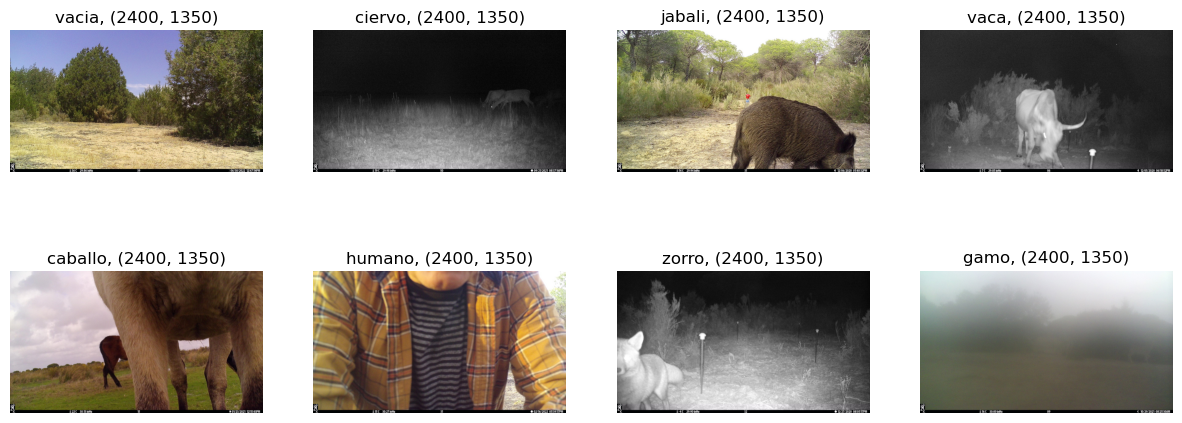

In [15]:
## Viz Random Sample from each class
plt.figure(figsize=(15, 12))
# iterate over dictionary items (class label, image array)
for i, (cls,img) in enumerate(image_dict.items()): 
    # create a subplot axis
    ax = plt.subplot(4, 4, i + 1)
    # plot each image
    plt.imshow(img)
    # set "class name" along with "image size" as title 
    plt.title(f'{cls}, {img.size}')
    plt.axis("off")

### Distribución de datos

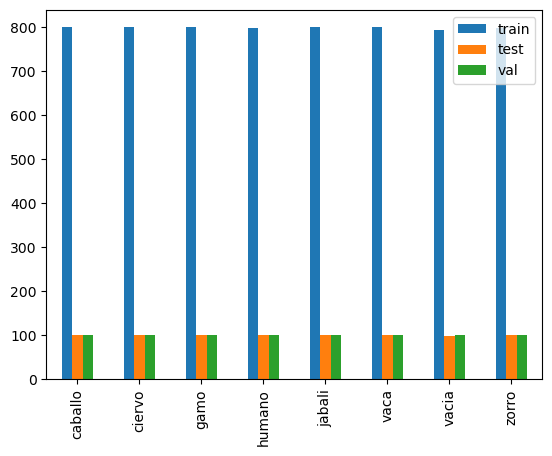

In [16]:
train_labels = df_train["class"]
test_labels = df_test["class"]
val_labels = df_val["class"]
# class_names = df_train["class"].unique()

class_names, train_counts = np.unique(train_labels, return_counts=True)
_, test_counts = np.unique(test_labels, return_counts=True)
_, val_counts = np.unique(val_labels, return_counts=True)

pd.DataFrame({'train': train_counts,
                    'test': test_counts,
                    'val': val_counts},
             index=class_names
            ).plot.bar()
plt.show()

In [17]:
print('\nLoading Train Data...')
train_data = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    shuffle = True,
    # seed=SEED,
    #image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    #label_mode="categorical"
)

print('\nLoading Validation Data...')
val_data = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    shuffle = False,
    # seed=SEED,
    #image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    #label_mode="categorical"
)

print('\nLoading Test Data...')
test_data = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    shuffle = False,
)


Loading Train Data...
Found 6391 files belonging to 8 classes.

Loading Validation Data...
Found 800 files belonging to 8 classes.

Loading Test Data...
Found 799 files belonging to 8 classes.


# Data Preprocessing

In [18]:
# Data Processing Stage with resizing and rescaling operations
data_preprocess = keras.Sequential(
    name="data_preprocess",
    layers=[
        layers.Resizing(TARGET_IMG_HEIGHT, TARGET_IMG_WIDTH), # Shape Preprocessing
        layers.Rescaling(1.0/255), # Value Preprocessing
    ]
)

# Data Processing con data augmentation
data_augmentation = keras.Sequential(
    name="data_augmentation",
    layers=[
        layers.Rescaling(1.0/255), # Value Preprocessing
        layers.Resizing(TARGET_IMG_HEIGHT, TARGET_IMG_WIDTH), # Shape Preprocessing

        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),

        tf.keras.layers.RandomContrast(factor = 0.5), # (x - mean) * contrast_factor + mean
        tf.keras.layers.RandomBrightness(factor = 0.3, value_range=(0,1)),
        tf.keras.layers.GaussianNoise(0.1),

        # tf.keras.layers.CenterCrop(50,50)
        # tf.keras.layers.RandomCrop(50,50)
        # tf.keras.layers.RandomZoom(50,50)


        tf.keras.layers.RandomTranslation(
            height_factor = 1,
            width_factor= 1,
            fill_mode='wrap',
            interpolation='bilinear',
            seed=None,
            fill_value=0.0,
        )
    ]
)

### Data Augmentation

In [19]:
# Obtener un lote de imágenes originales del conjunto de datos
batch_images, batch_labels = next(iter(train_data))

# Aplicar el data_augmentation a cada imagen de muestra
augmented_images = data_augmentation(batch_images, training=True)

2023-07-05 11:59:15.310109: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [6391]
	 [[{{node Placeholder/_4}}]]
2023-07-05 11:59:15.310385: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [6391]
	 [[{{node Placeholder/_0}}]]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

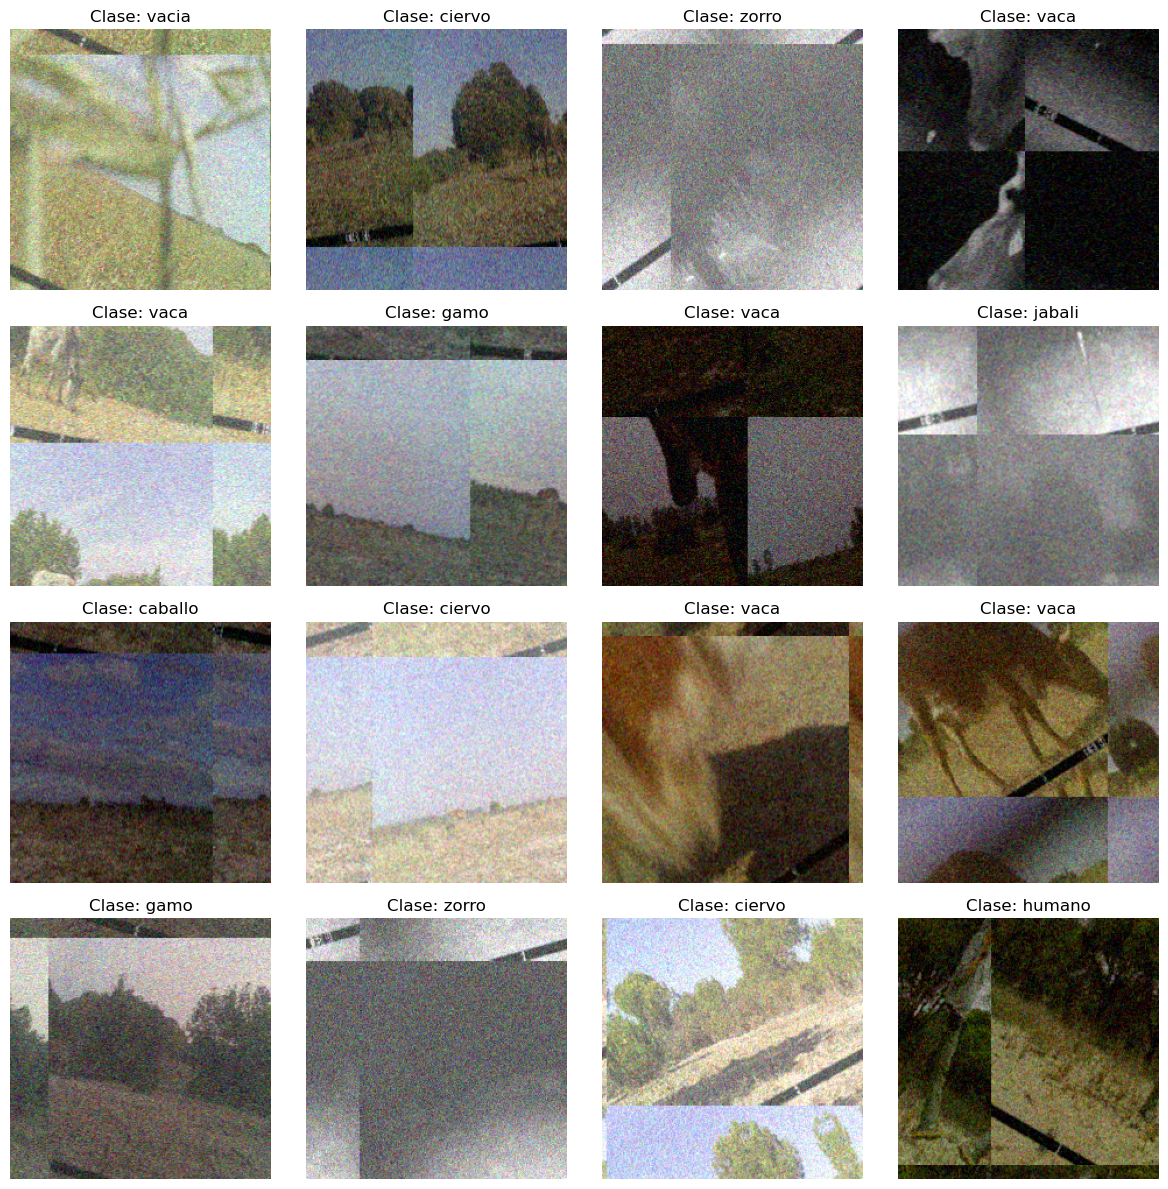

In [20]:
# Visualizar las imágenes aumentadas con sus etiquetas
plt.figure(figsize=(12, 12))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(augmented_images[i])
    plt.title(f"Clase: {class_names[batch_labels[i]]}")
    plt.axis("off")
plt.tight_layout()
plt.show()

In [21]:
# Perform Data Processing on the train, val, test dataset
train_ds = train_data.map(lambda x, y: (data_augmentation(x), y))
val_ds = val_data.map(lambda x, y: (data_preprocess(x), y))
test_ds = test_data.map(lambda x, y: (data_preprocess(x), y))

# Cronh

### Modelo

In [22]:
def conv_block(inputs, filters):
    x = tf.keras.layers.Conv2D(filters, kernel_size=(3, 3), strides=1, padding='same')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Dropout(DROPOUT_FACTOR)(x)
    return x

def conv_blocks(inputs, n_filters):
    x = conv_block(inputs, n_filters)
    x = conv_block(x, n_filters)
    x = conv_block(x, n_filters)
    return x

In [23]:
# Añadir capas
inputs = tf.keras.Input(shape=TARGET_SHAPE)

# Feature extraction blocks
x = conv_blocks(inputs, 32)
x = tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding='same')(x)
x = tf.keras.layers.Dropout(DROPOUT_FACTOR)(x)

x = conv_blocks(x, 48)
x = tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding='same')(x)
x = tf.keras.layers.Dropout(DROPOUT_FACTOR)(x)

x = conv_blocks(x, 56)
x = tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding='same')(x)
x = tf.keras.layers.Dropout(DROPOUT_FACTOR)(x)

x = conv_blocks(x, 64)
x = tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding='same')(x)
x = tf.keras.layers.Dropout(DROPOUT_FACTOR)(x)

x = conv_blocks(x, 64)
x = tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding='same')(x)
x = tf.keras.layers.Dropout(DROPOUT_FACTOR)(x)

x = conv_blocks(x, 96)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(DROPOUT_FACTOR)(x)

# Classification layer
predictions = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(x)

In [24]:
# Modelo Final
model = Model(inputs=inputs, outputs=predictions)

In [25]:
# Compilar el modelo
model.compile(optimizer=OPTIMIZER,
              loss=LOSS,
              metrics=METRICS)

In [26]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 32)     128       
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 224, 224, 32)      0         
                                                                 
 dropout (Dropout)           (None, 224, 224, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 32)      9248      
                                                             

 re_lu_11 (ReLU)             (None, 28, 28, 64)        0         
                                                                 
 dropout_14 (Dropout)        (None, 28, 28, 64)        0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 dropout_15 (Dropout)        (None, 14, 14, 64)        0         
                                                                 
 conv2d_12 (Conv2D)          (None, 14, 14, 64)        36928     
                                                                 
 batch_normalization_12 (Bat  (None, 14, 14, 64)       256       
 chNormalization)                                                
                                                                 
 re_lu_12 (ReLU)             (None, 14, 14, 64)        0         
          

### Entrenamiento

In [28]:
history_mobilenet = model.fit(
    train_ds,
    epochs=NUM_EPOCHS,
    validation_data=val_ds,
    callbacks=CALLBACKS,
    shuffle=True
)

Epoch 1/100


2023-07-05 11:59:44.443438: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_21' with dtype resource
	 [[{{node Placeholder/_21}}]]
2023-07-05 11:59:44.443874: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_18' with dtype resource
	 [[{{node Placeholder/_18}}]]


200/200 [==============================] - ETA: 0s - loss: 2.1738 - accuracy: 0.1355

2023-07-05 12:20:44.245212: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [800]
	 [[{{node Placeholder/_4}}]]
2023-07-05 12:20:44.245463: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [800]
	 [[{{node Placeholder/_4}}]]



Epoch 1: val_accuracy improved from -inf to 0.12500, saving model to ../../Models/Cronh_v2/best_model_20230705_1159_val_acc_0.1250.h5
200/200 [==============================] - 1289s 6s/step - loss: 2.1738 - accuracy: 0.1355 - val_loss: 2.1034 - val_accuracy: 0.1250 - lr: 0.0010
Epoch 2/100
200/200 [==============================] - ETA: 0s - loss: 2.1188 - accuracy: 0.1194
Epoch 2: val_accuracy did not improve from 0.12500
200/200 [==============================] - 1261s 6s/step - loss: 2.1188 - accuracy: 0.1194 - val_loss: 2.0968 - val_accuracy: 0.1250 - lr: 0.0010
Epoch 3/100
200/200 [==============================] - ETA: 0s - loss: 2.0889 - accuracy: 0.1338
Epoch 3: val_accuracy did not improve from 0.12500
200/200 [==============================] - 1259s 6s/step - loss: 2.0889 - accuracy: 0.1338 - val_loss: 2.0968 - val_accuracy: 0.1250 - lr: 0.0010
Epoch 4/100
200/200 [==============================] - ETA: 0s - loss: 2.0668 - accuracy: 0.1519
Epoch 4: val_accuracy did not impr

Epoch 28/100
200/200 [==============================] - ETA: 0s - loss: 1.6921 - accuracy: 0.3669
Epoch 28: val_accuracy did not improve from 0.14250
200/200 [==============================] - 1267s 6s/step - loss: 1.6921 - accuracy: 0.3669 - val_loss: 2.2056 - val_accuracy: 0.1250 - lr: 5.0000e-04
Epoch 29/100
200/200 [==============================] - ETA: 0s - loss: 1.6753 - accuracy: 0.3722
Epoch 29: val_accuracy did not improve from 0.14250
200/200 [==============================] - 1287s 6s/step - loss: 1.6753 - accuracy: 0.3722 - val_loss: 2.1969 - val_accuracy: 0.1250 - lr: 5.0000e-04
Epoch 30/100
200/200 [==============================] - ETA: 0s - loss: 1.6526 - accuracy: 0.3794
Epoch 30: val_accuracy did not improve from 0.14250
200/200 [==============================] - 1301s 6s/step - loss: 1.6526 - accuracy: 0.3794 - val_loss: 2.3589 - val_accuracy: 0.1250 - lr: 5.0000e-04
Epoch 31/100
200/200 [==============================] - ETA: 0s - loss: 1.6454 - accuracy: 0.3854
Ep

#### Resultados del entrenamiento

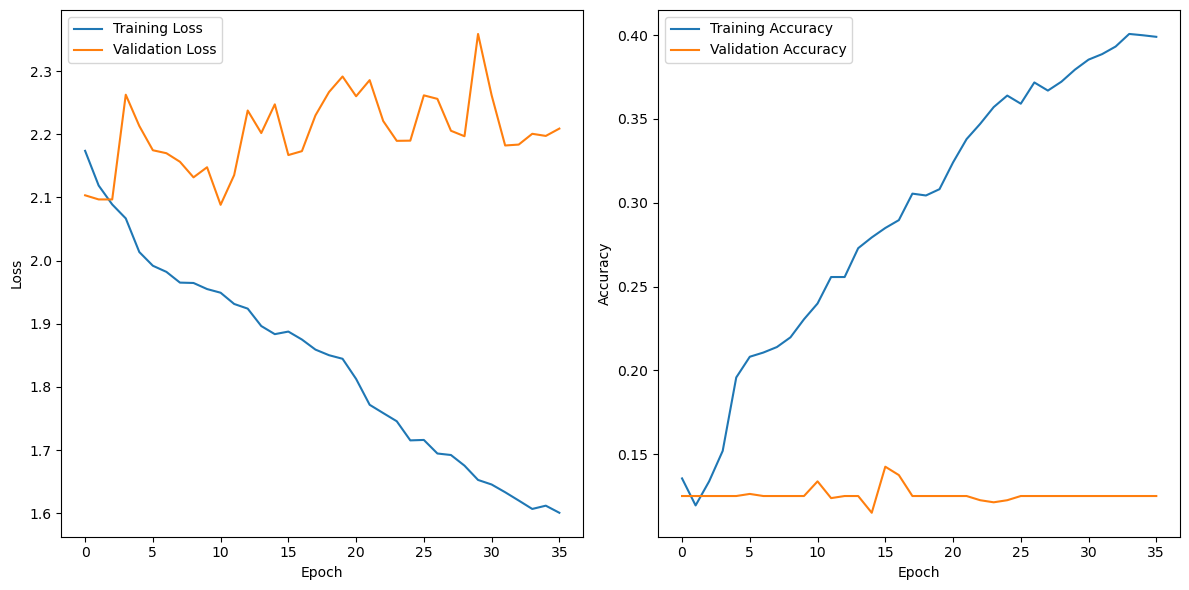

In [29]:
# Mostrar como ha ido el entrenamiento
plot_training(csvlogger_filename)

In [32]:
best_model_path = PATH + "Models/" + MODEL_NAME + "/best_model_20230705_1159_val_acc_0.1425.h5"
best_model = load_model(best_model_path)

In [33]:
best_model.evaluate(test_ds)

2023-07-06 18:27:03.909908: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [799]
	 [[{{node Placeholder/_4}}]]
2023-07-06 18:27:03.910415: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [799]
	 [[{{node Placeholder/_4}}]]


25/25 [==============================] - 29s 1s/step - loss: 2.1559 - accuracy: 0.1977


[2.155928373336792, 0.19774718582630157]

25/25 [==============================] - 33s 1s/step


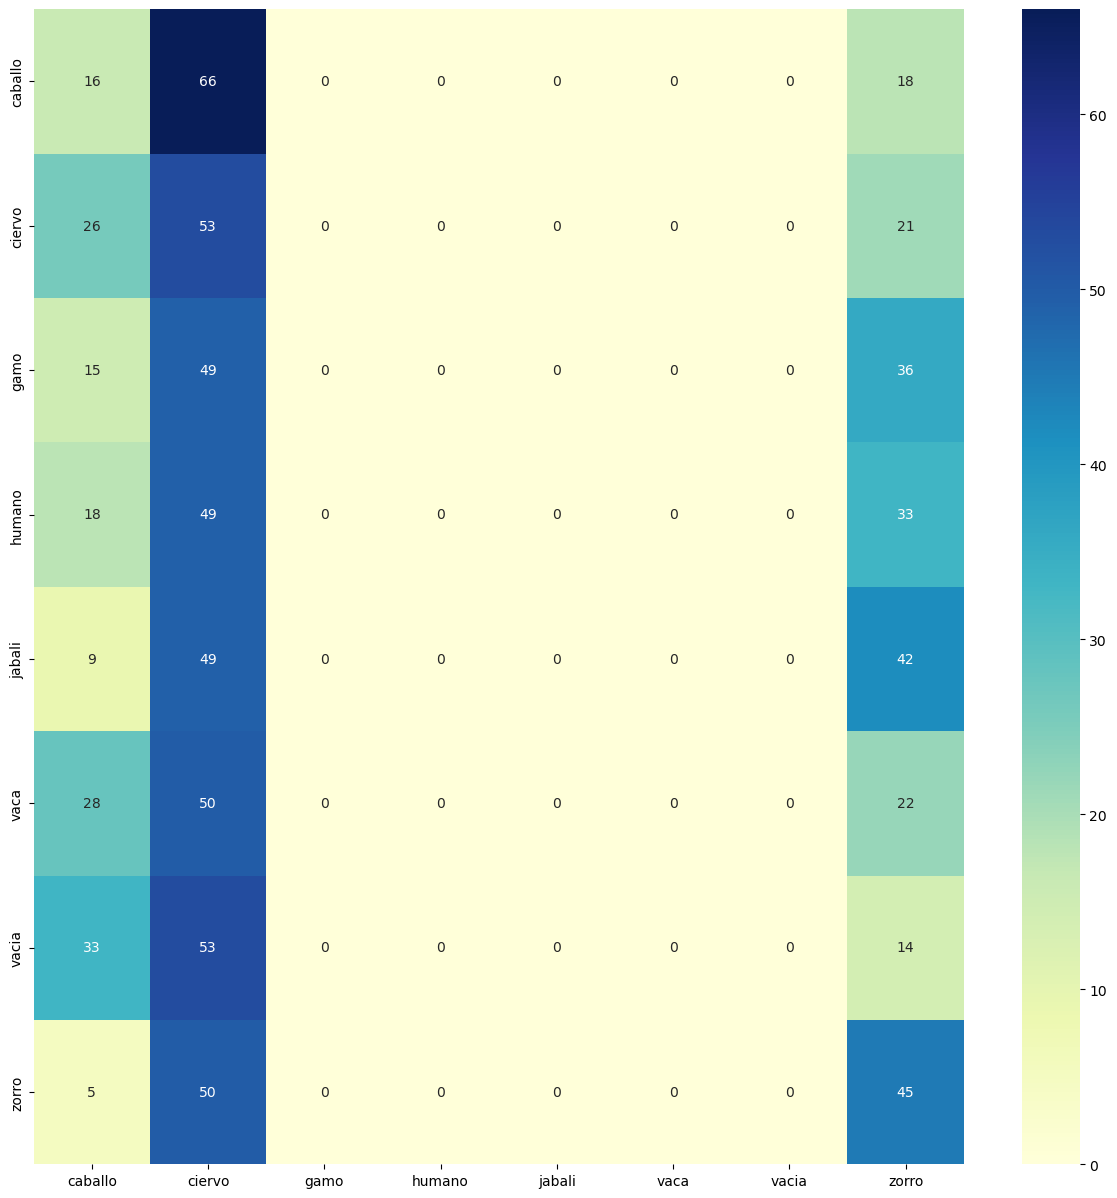

In [34]:
y_pred_val = best_model.predict(val_ds)
NotShuffled_ConfusionMatrix(y_pred_val, val_ds, val_data.class_names)

In [35]:
save_report(y_pred_val, val_ds, "val_")

25/25 [==============================] - 31s 1s/step


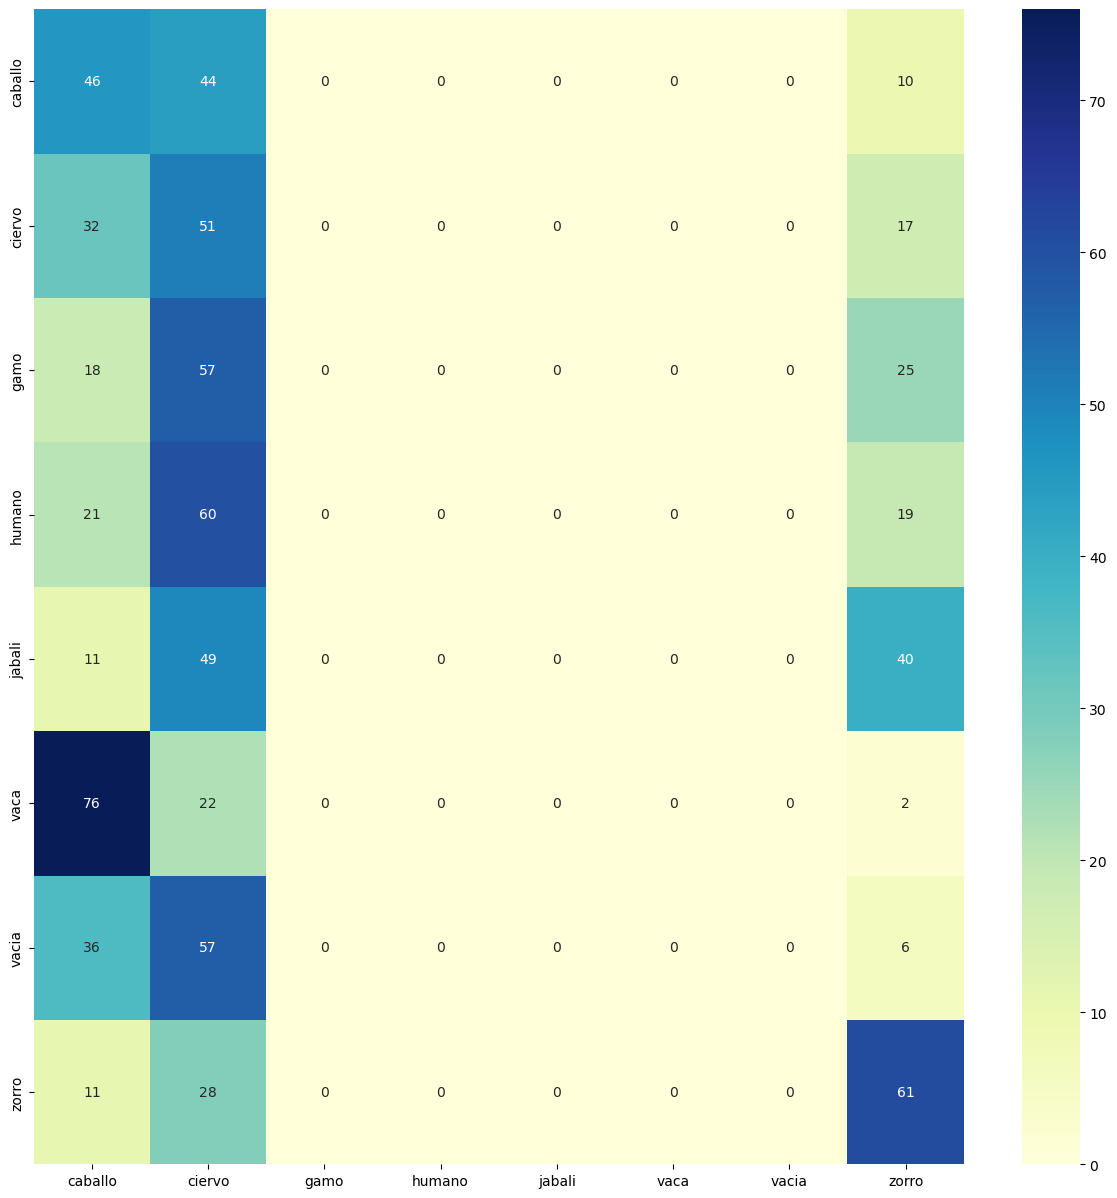

In [36]:
y_pred_test = best_model.predict(test_ds)
NotShuffled_ConfusionMatrix(y_pred_test, test_ds, test_data.class_names)

In [37]:
save_report(y_pred_test, test_ds, "test_")

2023-07-06 18:29:03.437741: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 481087488 exceeds 10% of free system memory.


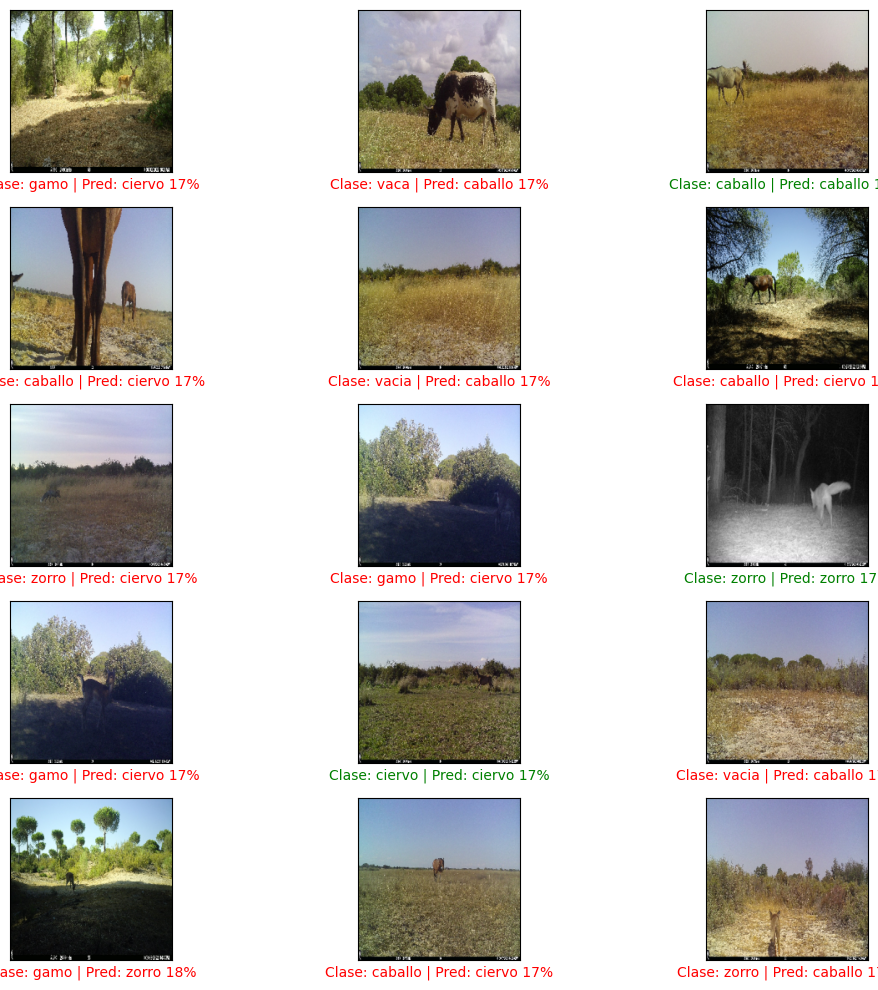

In [38]:
plot_predictions(y_pred_test, test_ds)